# Opening the box of autograd

    Thomas Moreau <thomas.moreau@inria.fr>
    Alexandre Gramfort <alexandre.gramfort@inria.fr>

    Notebook inspired from materials by J. Howard, S. Gugger.

1. [Data Generation](#1---Data-Generation)
2. [A Two-layers Neural Network](#2---A-Two-layers-Neural-Network)  
    2.1. [The-Forward-Pass](#2.1---The-Forward-Pass)  
    2.2. [The-Backward-Pass](#2.2---The-Backward-Pass)  
    2.3. [Training the NN](#2.3---Training-the-NN)  
    2.4. [Autograd](#2.4---Autograd)  
    2.5. [The PyTorch Magic](#2.5---The-PyTorch-Magic)  
    2.6. [Bonus - Implement-a-Convolutional-Layer](#2.6---Bonus---Implement-a-Convolutional-Layer)

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import check_random_state

### 1 - Data Generation

<a id='data'></a>

To test our model on very simple example, we will use Gaussian data.

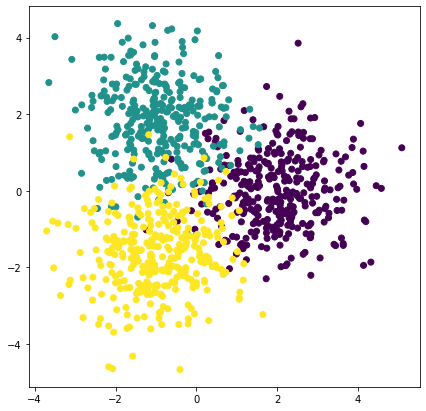

In [2]:
from utils import generate_data
from utils import plot_data, show_decision_boundary

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

l_mu = [MU1, MU2, MU3]
X, y = generate_data(l_mu, random_state=42)

# One hot encoded target
y_ = OneHotEncoder().fit_transform(y[:, None]).toarray()

plot_data(X, y)

##  2 - A Two-layers Neural Network

We want to build a network with one hidden layer. The number of neurons in this network will be a variable called `n_neurons`.

### 2.1 - The Forward Pass

The *forward pass* is where we compute the output of the model on a given input, based on the matrix products. As we define our first neural net, we will also delve into the problem of properly initializing the weights, which is crucial for making training start properly.

A network is defined by its parameters. We will thus define a dictionary to describe a network, this dictionary being composed of four elements named `W1`,`b1`,`W2`,`b2`. We use RELU as activation functions, the softmax as output function and the negative log-likelihood as the loss function (also called cross-entropy). 

The equations defining the network are 

\begin{align*}
z^{(1)} & = X W_{(1)}^\top + b^{(1)}\\
a^{(1)} & = \text{RELU}(z^{(1)}) \\
z^{(2)} & = a^{(1)} W_{(2)}^\top + b^{(2)} \\
a^{(2)} & = \hat{y} = \textrm{softmax}(z^{(2)}) 
\end{align*}

where $X$ is the input array of size $(n , 2)$ (where $n$ is the number of data points or the batch-size), $z^{(1)}, a^{(1)}$ are of size ($n$, `n_neurons`), $z^{(1)}, a^{(1)}$ are of size ($n$, `n_classes`) and $b^{(1)},  b^{(2)}$ are vectors of size `n_neurons` and `n_classes` respectively. Note that $ \hat{y}$ is the ($n$, `n_classes`) array containing the predicted probabilities for each class as above.


<div class="alert alert-success">

**Questions:**

* Create a function `init_model(n_features, n_neurons, n_classes, random_state=None)` which creates a model as a dictionary holding all the necessary weights `W1, b1, W2, b2`.
* Create a function `forward(model, X)` which computes the output of the model.

_Initialize the weights `W1, W2` with random Gaussian entries $\mathcal N\Big(0, \frac{2}{n_{in}}\Big)$, $n_{in}$ is the input size of the layers (2 for `W1` and `n_neurons` for `W2`), and the bias `b1, b2` to 0._

</div>

_**Note:** If you wanna know more on why we use such Kaiming initialization for the weights, take a look at `01d-note-on-layers-initialization.ipynb`._

Solution for the `init_model` function in `solutions/01b_1a_create_model.py`  
and for the `forward` function in `solutions/01b_1b_create_model.py`


In [3]:
def init_model(n_features, n_neurons, n_classes, random_state=None):
    """Create a dictionary with the parameter of the 2-layer NN.

    Parameters
    ----------
    n_features : int
        Dimension of the input of the network.
    n_neurons : int
        Dimension of the hidden layer.
    n_classes : int
        Dimension of the output of the network.
    random_state : RandomState | int | None
        Random state to generate reproducible results.

    Returns
    -------
    model : dict
        Dictionary containing all the parameters of the model,
        `W1, b1, W2, b2` as np.ndarrays.
    """
    rng = check_random_state(random_state)

    ####################
    # TODO
    w_init = lambda x, y: np.array([[np.random.normal(0, np.math.sqrt(2/x)) for _ in range(y)] for _ in range(x)])
    model = {
        # 'W1': w_init(n_features, n_neurons),
        'W1': w_init(n_neurons, n_features),
        'b1': np.zeros(n_neurons),
        # 'W2': w_init(n_neurons, n_classes),
        'W2': w_init(n_classes, n_neurons),
        'b2': np.zeros(n_classes)
    }
    
    # model = {
    #     'W1': rng.randn(n_neurons, n_features) * np.sqrt(2 / n_features),
    #     'b1': np.zeros(n_neurons),
    #     'W2': rng.randn(n_classes, n_neurons) * np.sqrt(2 / n_neurons),
    #     'b2': np.zeros(n_classes)
    # }
    # END TODO
    ##############

    return model


In [4]:
from scipy.special import softmax


def forward(model, X):
    """Compute the output of the model for a given input.

    Parameters
    ----------
    model : dict
        Dictionary containing all the parameters of the model,
        `W1, b1, W2, b2` as np.ndarrays.
    X : ndarray, shape (batch_size, n_features)
        Input of the network.

    Returns
    -------
    y_proba : ndarray, shape (batch_size, n_classes)
        Output of the network. For each sample in the batch, each
        coordinate i corresponds to the probability of being of
        the class i.
    """
    W1, b1 = model['W1'], model['b1']
    W2, b2 = model['W2'], model['b2']

    ####################
    # TODO
    z1 = X.dot(W1.T) + b1[None]
    a1 = np.maximum(z1, 0)
    z2 = a1.dot(W2.T) + b2[None]
    y_hat = softmax(z2, axis=1)

    # END TODO
    ##############

    return y_hat


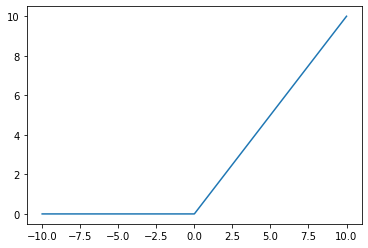

In [5]:
t = np.linspace(-10, 10, 1000)
relu_t = np.maximum(t, 0)
plt.plot(t, relu_t)

Model accuracy: 0.497


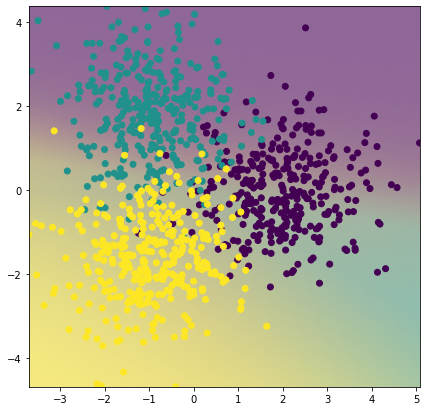

In [6]:
# Test
n_neurons = 10
n_samples, n_features = X.shape

# Use the one-hot encoded target
n_classes = y_.shape[1]


model = init_model(n_features, n_neurons, n_classes, random_state=118)
y_proba = forward(model, X)
y_pred = y_proba.argmax(axis=1)

print(f"Model accuracy: {np.mean(y_pred == y)}")

show_decision_boundary(partial(forward, model), data=(X, y))

### 2.2 - The Backward Pass

Now, we would like to train this model using the negative log-likelyhood loss (_a.k.a_ the cross-enropy loss), as done in the `logreg` notebook. Recall that the **nll** is given by
$$
\ell(Y, \mathbf{\hat{y}}) = - \frac{1}{n} \sum_{i=1}^n \sum_{k=0}^1 Y_{k, i} \log(\mathbf{\hat{y}}_{k, i})
$$
where $Y$ corresponds to the one-hot encoded target. As we saw previously, to train a model, we will need to compute all the gradients of this loss with respect to its parameters. The way this is done for a neural network is with the so-called *backward pass*. If we consider the logit $z^{(2)}$ (the output of the network without the soft-max), we have already computed the gradient of the **nll** relatively to them _i.e.,_
$$
\frac{\partial \ell }{\partial z^{(2)}_j} = \mathbf{\hat{y}}_j - Y_j.
$$

Note that deriving the log of the softmax makes calculations much easier.

<div class="alert alert-success">

**Exercise:**

* Create a function `cross_entropy_and_grad(logit, y)` that computes the CE-loss and gradient from the logit (output of the model without the softmax).
</div>

The solution is in `solutions/01b_2a_cross_entropy_grad.py`

In [7]:
def cross_entropy_and_grad(logit, y):
    """Output of the model without the softmax.

    Also returns the intermediate activations.

    Parameters
    ----------
    logit, y : ndarray, shape (batch_size, n_classes)
        Output of the model and target associated to these samples.

    Returns
    -------
    loss : float
        Loss of the model for these samples
    grad : ndarray, shape (batch_size, n_classes)
        Gradient of the loss relative to logit.
    """
    ##################################
    # TODO
    y_hat = softmax(logit, axis=1)
    loss = -(np.log(y_hat) * y).sum(axis=1).mean()
    grad = (y_hat - y) / y.shape[0]

    # END TODO
    ####################################
    return loss, grad


We now compute the derivative w.r.t $z^{(1)}$. For this, apply the chain rule and recall that $\text{RELU} '(x) = \mathbb 1\{RELU(x) > 0\}$:
\begin{align*}
\frac{\partial \ell }{\partial z^{(1)}_j}
&= \sum_k \frac{\partial \ell}{\partial z^{(2)}_k} \frac{\partial z^{(2)}_k}{\partial z^{(1)}_j}
= \sum_k \frac{\partial \ell}{\partial z^{(2)}_k} \sum_{m}\frac{\partial z^{(2)}_k}{\partial a^{(1)}_m}\frac{\partial a^{(1)}_m}{\partial z^{(1)}_j}
= \sum_k \frac{\partial \ell}{\partial z^{(2)}_k} \frac{\partial z^{(2)}_k}{\partial a^{(1)}_j}\frac{\partial a^{(1)}_j}{\partial z^{(1)}_j}\\
&= \sum_k \frac{\partial \ell}{\partial z^{(2)}_k} W_{k, j}^{(2)} \mathbb 1\{a^{(1)}_{j} > 0\}\\
&= \frac{\partial \ell}{\partial z^{(2)}} W_{:, j}^{(2)} \mathbb 1\{a^{(1)}_{j} > 0\}
\end{align*}

Finally, denoting $\odot$ the column-wise multiplication, we get
$$
\frac{\partial \ell }{\partial z^{(1)}} = \frac{\partial \ell}{\partial z^{(2)}}^\top W^{(2)} \odot \mathbb 1\{a^{(1)} > 0\}.
$$


Finally, we compute the gradient of the model parameters also using the chain rule:
\begin{align*}
\frac{\partial \ell }{\partial W^{(2)}}  & = \frac{\partial \ell }{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial W^{(2)}} = a^{(1)\top}\frac{\partial \ell }{\partial z^{(2)}}; &
\frac{\partial \ell }{\partial W^{(1)}} & = X^\top\frac{\partial \ell}{\partial z^{(1)}}\\
\frac{\partial \ell }{\partial b^{(2)}} & = \sum_{i=1}^n\frac{\partial \ell}{\partial z^{(2)}_i}; &
\frac{\partial \ell }{\partial b^{(1)}} & = \sum_{i=1}^n\frac{\partial \ell}{\partial z^{(1)}_i}
\end{align*}

Here, we see that to be able to easily compute the gradient, we will need to first store all the intermediary steps of our forward pass.

Then, we can compute the gradient for each parameter by following the simple computation rules described above.

<div class="alert alert-success">

**Exercice:**

1. Create a function `forward_train(model, X)` that computes the output of the model without the softmax and returns the intermediate results necessary for the backward pass in a dict `ctx`.
2. Create a function `backward(model, grad_output, ctx)` that computes the gradient for each parameter of the model. The output will be a dictionary `{parameter_name => gradient}`

</div>

Solutions are in:

1. `solutions/01b_2b_forward_train.py`
2. `solutions/01b_2c_backward.py`

In [8]:

def forward_train(model, X):
    """Output of the model without the softmax.

    Also returns the intermediate activations.

    Parameters
    ----------
    model : dict
        Dict containing all the network parameters.
    X : ndarray, shape (batch_size, n_features)
        The input of the model.

    Returns
    -------
    logit : ndarray, shape (batch_size, n_classes)
        The unnormalized output of the model
    ctx : dict
        The intermediate values in the network.
    """
    ##################################
    # TODO
    W1, b1 = model['W1'], model['b1']
    W2, b2 = model['W2'], model['b2']
    
    z1 = X.dot(W1.T) + b1[None]
    a1 = np.maximum(z1, 0)
    z2 = a1.dot(W2.T) + b2[None]

    ctx = dict(z2=z2, a1=a1, z1=z1, X=X)

    # END TODO
    ####################################

    return z2, ctx


In [9]:
def backward(model, output_grad, ctx):
    """Output of the model without the softmax.

    Also returns the intermediate activations.

    Parameters
    ----------
    model : dict
        Dict containing all the network parameters.
    ctx : dict
        The intermediate values in the network.
    grad_output : ndarray, shape (batch_size, n_classes)
        Gradient of the loss relative to the output of the model.

    Returns
    -------
    all_grad : dict {parameter_name => gradient}
        Gradient of each parameter of the model.
    """
    ##################################
    # TODO
    a1, X = ctx['a1'], ctx['X']

    # Gradient of the parameters of the first layer
    grad_W2 = (output_grad.T @ a1)
    grad_b2 = (output_grad).sum(axis=0)

    # Gradient of the intermediate steps
    grad_a1 = output_grad @ model['W2']
    grad_z1 = grad_a1 * (a1 > 0)

    # Gradient of the parameters of the first layer
    grad_W1 = (grad_z1.T @ X)
    grad_b1 = (grad_z1).sum(axis=0)

    all_grad = dict(W1=grad_W1, b1=grad_b1, W2=grad_W2, b2=grad_b2)

    # END TODO
    ####################################

    return all_grad


You can use the following cell to test that your functions are giving the proper results.

In [10]:
# Test the functions

# Check that the gradients have the correct shape
logit, ctx = forward_train(model, X)
loss, grad_output = cross_entropy_and_grad(logit, y_)
all_grad = backward(model, grad_output, ctx)
for p in model:
    assert all_grad[p].shape == model[p].shape

# if the model output is always right, all gradients should be 0
perfect_logit = 1e2 * (y_ - 1)
loss, grad_output = cross_entropy_and_grad(perfect_logit, y_)
all_grad = backward(model, grad_output, ctx)
for g in all_grad.values():
    assert np.allclose(g, 0)

### 2.3 Training the NN


Now, we are ready to implement the training loop of our neural network by piecing together all the components. The algorithm we use is the SGD

<div class="alert alert-success">

**Exercise:**
    
* Train a model using the functions that you have implemented.
* Plot the evolution of the training loss and the decision boundary.

</div>

Solution in `solutions/01b_3_training_loop.py`

Iterarion 0 - train accuracy: 0.435
Iterarion 100 - train accuracy: 0.595
Iterarion 200 - train accuracy: 0.594
Iterarion 300 - train accuracy: 0.604
Iterarion 400 - train accuracy: 0.624
Iterarion 500 - train accuracy: 0.679
Iterarion 600 - train accuracy: 0.724
Iterarion 700 - train accuracy: 0.794
Iterarion 800 - train accuracy: 0.852
Iterarion 900 - train accuracy: 0.89
Iterarion 1000 - train accuracy: 0.901
Iterarion 1100 - train accuracy: 0.907
Iterarion 1200 - train accuracy: 0.909
Iterarion 1300 - train accuracy: 0.912
Iterarion 1400 - train accuracy: 0.912
Iterarion 1500 - train accuracy: 0.914
Iterarion 1600 - train accuracy: 0.915
Iterarion 1700 - train accuracy: 0.916
Iterarion 1800 - train accuracy: 0.916
Iterarion 1900 - train accuracy: 0.917
Iterarion 2000 - train accuracy: 0.921
Iterarion 2100 - train accuracy: 0.922
Iterarion 2200 - train accuracy: 0.922
Iterarion 2300 - train accuracy: 0.922
Iterarion 2400 - train accuracy: 0.922
Iterarion 2500 - train accuracy: 0.923

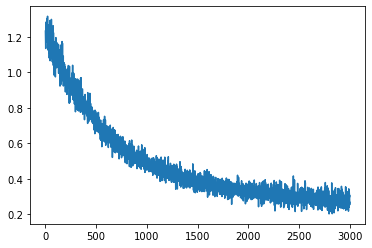

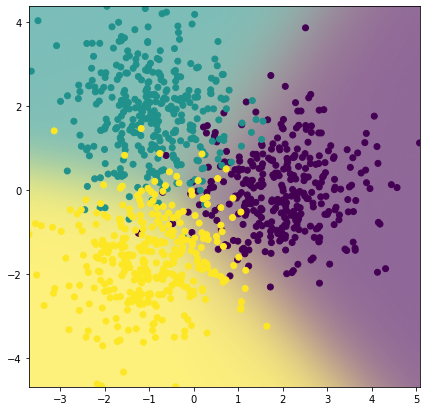

In [11]:
#####################################
# Logger to allow simple plot for the
# evolution of the training loss and
# the decision boundary.
from copy import deepcopy

pobj = []
l_predict_proba = []


def logger(i, model, loss):
    pobj.append(loss)
    l_predict_proba.append(partial(forward, model=deepcopy(model)))

    if i % 100 == 0:
        y_pred = forward(model, X).argmax(axis=1)
        print(f"Iterarion {i} - train accuracy: {np.mean(y_pred == y)}")


############################

lr = 1e-3
batch_size = 128
rng = check_random_state(29)

# Initialize the model
model = init_model(n_features, n_neurons, n_classes, random_state=118)

for i in range(3000):
    
    
    ########################
    # TODO - implement SGD
    
    # Sample a batch
    idx = rng.choice(range(n_samples), size=batch_size,
                     replace=False)
    X_batch, y_batch = X[idx], y_[idx]

    # Compute the loss and gradient
    logit, ctx = forward_train(model, X_batch)
    loss, grad_output = cross_entropy_and_grad(logit, y_batch)
    all_grad = backward(model, grad_output, ctx)

    for p in model:
        model[p] -= lr * all_grad[p]
    
    # END TODO
    ######################

    logger(i, model, loss)

plt.plot(pobj)

show_decision_boundary(partial(forward, model), data=(X, y))

In [12]:
# from utils import create_animation
# create_animation(l_predict_proba, X, y, iter_step=50)

<div class="alert alert-success">

**Question:**

* What if we ask you to code a 10-layer neural network? a 100-layer network?
    
</div>

### 2.4 - Autograd


We will now see how one can implement an API to easily chain operators and compute the gradients using back propagation for the same architecture.

For each operation in our model, we used to have two associated steps: a forward pass step that computes the output of the operation and a backward pass that computes the gradient of all the inputs of the operation. Instead of writing them separately, we can create a class to wrap them together.

In order to simplify chaining the operation, this class can also store the inputs and outputs for the backward pass and we will store the gradient of a parameter `param` in an attribute `param.g`, so once it is computed, it is accessible in other function. To be able to easily do that, we will use `Parameter` instead of `ndarray` as it is not possible to store extra attribute `g` in a`ndarray`. Let's first convert our model initialization to get `Parameter` instead of `ndarray`.

In [13]:
# Wrapper class around ndarray so we can add
# an attribute `g` at runtime.
class Parameter(np.ndarray):
    def __new__(cls, input_array):        
        obj = np.asarray(input_array).view(cls)
        obj.g = None
        return obj

    def __array_finalize__(self, obj):
        if obj is None:
            return
        self.your_new_attr = getattr(obj, 'g', None)


def init_model_parameters(*args, **kwargs):
    return {
        k: Parameter(v) for k, v in init_model(*args, **kwargs).items()
    }

model = init_model_parameters(n_features, n_neurons, n_classes)

We will create our own `autograd` library with three operation possible:
* a `Relu` layer, that have no parameter and simply compute the output of the RELU,
* a `Linear` layer with parameters `W, b`,
* a `CrossEntropyLogit` loss that computes the softmax of its input and then output the cross entropy.

We start by defining the `Relu` layer with a `forward` and a `backward` operation:

In [14]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = Parameter(np.maximum(inp, 0.))
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp > 0) * self.out.g

In [15]:
x = Parameter(np.random.randn(100))
relu = Relu()
y = relu(x)
y.g = np.ones(100)
relu.backward()
all(x.g == (x > 0))

True

Note that `__call__` is a builtin name in Python that will make our class callable. This is what will be executed when we type `y = Relu()(x)`.

<div class="alert alert-success">


**Exercise:**

For the `CrossEntropyLogit` loss, implement:

* The loss computation from the logit in `__call__(logit, y)`, which will store the input, the target and output as attributes of the class and return the cross-entropy loss computed from the logit,
* The backward operation in `backward()`, which will store the gradient of the input `logit` as an attribute `.g` of the tensor, as done in the `Relu` layer.
    
_**Hint:** we have already computed these operations in `cross_entropy_and_grad`._

</div>

Solution in `solutions/01b_4a_autograd_cross_entropy.py`

In [16]:

class CrossEntropyLogit():
    def __call__(self, logit, y):
        ######################
        # TODO
        self.logit = logit
        self.y = y
        self.y_hat = softmax(logit, axis=1)
        self.out = -(np.log(self.y_hat) * y).sum(axis=1).mean() # loss

        # END TODO
        ########################
        return self.out

    def backward(self):
        ######################
        # TODO
        self.logit.g = self.y_hat - self.y

        # END TODO
        ########################
        pass


In [17]:
x = Parameter(np.random.randn(100, 10))
y = np.zeros((100, 10))
y[:, 0] = 1
ce = CrossEntropyLogit()
loss = ce(x, y)
ce.backward()
loss, ce(x - 1e-1*x.g, y)

(Parameter(2.7071612), Parameter(2.60948905))

<div class="alert alert-success">


**Exercise:**

For the `Linear` layer, implement:

* The forward operation in `__call__(inp)`. This will store the input and output of the operation as attributes of the class instance,
* The backward operation in `backward()`, which will store the gradient of the input and of the parameters as attributes `.g` of the corresponding tensors, as done in the `Relu` layer.

_**Hint:** these operations have also been computed previsouly in `backward`, when computing the gradient of the parameters  relatively to the gradient of the intermediate steps._

</div>

Solution in `solutions/01b_4b_autograd_linear.py`

In [18]:

class Linear():
    def __init__(self, w, b):
        self.w, self.b = w, b

    def __call__(self, inp):
        ######################
        # TODO
        self.inp = inp
        self.out = Parameter(inp @ self.w.T + self.b)

        # END TODO
        ########################
        return self.out

    def backward(self):

        ######################
        # TODO
        self.b.g = self.out.g.sum(axis=0)
        self.w.g = self.inp.T @ self.out.g / self.inp.shape[0]
        self.inp.g = self.out.g @ self.w
        # END TODO
        ########################


We can now implement a neural network by chaining these operations!

<div class="alert alert-success">

**Exercise**

Implement the same neural network as before using the created layers.

* The initializer `__init__(self, model)` stores a list of layers and the `loss`.
* The forward loop `__call__(X, y)`  will chain the call to the layers in `self.layers` and output the loss.
* The backward loop `backward()` will call the backward of the `layers` in the right order. 

</div>

Solution in `solutions/01b_5_autograd_neural_network.py`

In [19]:

class Network():
    def __init__(self, model):
        self.layers = [
            Linear(model['W1'], model['b1']), Relu(),
            Linear(model['W2'], model['b2']),
        ]
        self.loss = CrossEntropyLogit()

    def __call__(self, X, y):

        X, y = Parameter(X), Parameter(y)
        ######################
        # TODO
        out = X
        for layer in self.layers:
            out = layer(out)
        return self.loss(out, y)

        # END TODO
        ########################

    def backward(self):

        ######################
        # TODO
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

        # END TODO
        ########################


What is really nice about this refactoring and registering things as layers of our model is that the forward and backward passes are now really easy to write. If we want to instantiate our model, we just need to write:

In [20]:
model = init_model_parameters(n_features, n_neurons, n_classes, random_state=0)
net = Network(model)

The forward pass can then be executed with:

In [21]:
loss = net(X, y_)
loss

Parameter(2.26766356)

And the backward pass with:

In [22]:
net.backward()

for p in model.values():
    print(p.g)

[[ 0.07671716 -0.03079144 -0.26549562 -0.5012309  -0.0270227   0.0395943
   0.04144789  0.02469531 -0.71541693  0.02243137]
 [-0.33409631  0.34822558 -0.47864528 -0.5845102   0.31827413 -0.23063158
  -0.18404073 -0.08333626 -1.2363213  -0.1382782 ]]
[-164.58447229  109.52469378  267.39666823  395.98164911 -132.47841673
  -94.07045431   26.24817228  -45.21381015  700.77065987  -77.18469288]
[[ 5.39204709e-02  4.68600319e-02 -1.00780503e-01]
 [ 6.56023144e-02 -6.53645390e-02 -2.37775425e-04]
 [ 8.10355757e-02  5.00069486e-01 -5.81105061e-01]
 [ 7.16815117e-02  1.42279436e-01 -2.13960948e-01]
 [-4.86247092e-04  3.53259216e-03 -3.04634507e-03]
 [ 6.09468282e-02 -6.49883018e-02  4.04147363e-03]
 [ 1.02958487e-02 -5.21338124e-03 -5.08246745e-03]
 [ 3.05068852e-02 -3.35250236e-02  3.01813835e-03]
 [ 6.45874401e-02  3.79614866e-01 -4.44202306e-01]
 [ 2.83724646e-02 -2.90275523e-02  6.55087689e-04]]
[ 134.73812136  166.10194857 -300.84006994]


The  `Linear`, `CrossEntropyLogit` and `Relu` classes we wrote have a lot in common, so we could make them all inherit from the same base class:

In [23]:
class LayerFunction():
    def __call__(self, *args):
        self.args = args
        self.out = Parameter(self.forward(*args))
        return self.out
    
    def forward(self):
        raise Exception('not implemented')

    def bwd(self):
        raise Exception('not implemented')

    def backward(self):
        self.bwd(self.out, *self.args)


Then we just need to implement `forward` and `bwd` in each of our subclasses:

In [24]:
class Relu(LayerFunction):
    def forward(self, inp):
        return np.maximum(inp, 0.)

    def bwd(self, out, inp):
        inp.g = (inp>0) * out.g


In [25]:
class Linear(LayerFunction):
    def __init__(self, w, b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp @ self.w.T + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w
        self.w.g = inp.T @ self.out.g
        self.b.g = out.g.sum(0)

In [26]:
class CrossEntropyLogit(LayerFunction):

    def forward (self, inp, targ):
        return -np.log(softmax(inp, axis=1)[targ == 1]).mean()

    def bwd(self, out, inp, targ): 
        inp.g = (inp - targ) / targ.shape[0]

The rest of our model can be the same as before. This is getting closer and closer to what PyTorch does.

### 2.5 - The PyTorch Magic

In `pytorch`, each basic function we need to differentiate is written as a `torch.autograd.Function` object that has a `forward` and a `backward` method. PyTorch will then keep trace of any computation we do to be able to properly run the backward pass, unless we set the `requires_grad` attribute of our tensors to `False`.

Writing one of these is (almost) as easy as writing our original classes. The difference is that we choose what to save and what to put in a context variable `ctx` (so that we make sure we don't save anything we don't need), and we return the gradients in the `backward` pass. It's very rare to have to write your own `Function` but if you ever need something exotic or want to mess with the gradients of a regular function, here is how to write one:

In [27]:
import torch
from torch.autograd import Function

class MyRelu(Function):
    @staticmethod
    def forward(ctx, i):
        result = i.clamp_min(0.)
        ctx.save_for_backward(i)
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        return grad_output * (i>0).float()

This function can then be applied to a tensor `x` using `MyRelu.apply(x)`.

In [28]:
# x = torch.randn(100, 100000, requires_grad=True)
# y = MyRelu.apply(x)
# y.sum().backward()
# print(x.grad)

<div class="alert alert-warning">

**Note**: When `MyRelu.apply` is called, its input is store in the `ctx`, which is attached to the output of the layer. This means that if the output (or other `autograd` enable operations from the output) is stored somewhere, the memory used to store this is not released. This can cause memory errors if many outputs are stored. A typical example is when one stores the `loss` object.
    
A good practice for logging is to either use `loss.detach()`, which drops the attached context, or stores the loss as a `float` and not a `torch.Tensor`, using `loss.item()`.
</div>

The structure used to build a more complex model that takes advantage of `Function` objects is a `torch.nn.Module`. It mostly helps to register all the trainable parameters, which as we've seen can be used in the training loop.

To implement an `nn.Module` you just need to:

- Make sure the superclass `__init__` is called first when you initialize it.
- Define any parameters of the model as attributes with `nn.Parameter`.
- Define a `forward` function that returns the output of your model.

As an example, here is the linear layer from scratch:

In [29]:
import torch.nn as nn

class LinearLayer(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(n_out, n_in) * np.sqrt(2/n_in))
        self.bias = nn.Parameter(torch.zeros(n_out))
    
    def forward(self, x):
        return x @ self.weight.t() + self.bias

As you see, this class automatically keeps track of what parameters have been defined:

In [30]:
lin = LinearLayer(10, 2)
p1, p2 = lin.parameters()
p1.shape, p2.shape

(torch.Size([2, 10]), torch.Size([2]))

It is thanks to this feature of `nn.Module` that we can just say `optimizer.step()` and have an optimizer loop through the parameters and update each one.

By using the linear layer from PyTorch (which uses the Kaiming initialization as well), the model we have just built up can be written like this:

In [31]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, nh),
            nn.ReLU(),
            nn.Linear(nh, n_out)
        )
        self.loss = mse
        
    def forward(self, x, targ):
        return self.loss(self.layers(x).squeeze(), targ)

### 2.6 - Bonus - Implement a Convolutional Layer

As a bonus question, you can try to implement a convolutional layer using the same API as before:

<div class='alert alert-info'>

**Bonus:** Implement a convolutional layer.

- You can use `torch.conv1d` or `np.convolve` for the forward pass.
- For the backward pass, if  the network output $f(z)$ with $z = x * k$, verify that the gradient can be computed as:
$$
    \frac{\partial f}{\partial k} = \frac{\partial f}{\partial z} * reverse(k)
$$
 where `reverse(k)` is the same as the kernel `k` but with the dimension of the convolution reversed (`reverse(k)[w, h] = k[W-w, H-h]`, for 1 sample/1 channel).

_**Hint:** the reverse correlation can be computed with `np.correlate`._

_**Hint 2:** The reverse of `full` mode is `valid` mode._

</div>

Solution in `solutions/01b_6_bonus_convolution.py`

In [32]:
import torch
import numpy as np


class Convolution(LayerFunction):
    def __init__(self, w, b):
        self.w, self.b = w, b
        self.k = w.shape[-1]

    def forward(self, inp):
        ####################
        # TODO

        # END TODO
        #####################
        return out

    def bwd(self, out, inp):

        ####################
        # TODO

        # END TODO
        #####################


################################
#  Check the gradient
#
rng = np.random.RandomState(42)
# shape: n_channel_out x n_channel_in x kernel_size
w = Parameter(rng.randn(8, 3, 4) / 4)
# shape: n_channel_out
b = Parameter(rng.randn(8))
# shape: batch_size x n_channel x n_times
inp = Parameter(rng.randn(2, 3, 28) / 28)

conv = Convolution(w, b)
out = conv(inp)
v = 0.5 * (out ** 2).sum()
out.g = out
conv.backward()


# Make sure that small movement reduces the loss
for i in range(500):
    w -= 1e-4 * w.g
    b -= 1e-4 * b.g
    out = conv(inp)
    out.g = out
    conv.backward()
    loss = 0.5 * (out ** 2).sum()
    assert loss <= v, (i, v - loss)

    v = loss

print("Looks good!")


IndentationError: expected an indented block (3128655229.py, line 30)